# Bayesian optimal experimental design

In this notebook, we compare the information gain different data sets reveal about the same model. We are given either the data of symptomatic infected or recovered individuals (the data is generated by an age-structured SEIR model) and the question is: Which data should we collect, given our model is the one with the highest evidence (see the example ex-evidence), in order to maximize our information gain? 

The information in the posterior relative to the prior after acquiring data is computed according to Skilling's nested sampling algorithm with the python package 'nestle': 

- Sivia D S and Skilling J. Data analysis: a Bayesian tutorial (Second Edition). Oxford Science Publications (2006)
- Skilling J. Nested sampling for general Bayesian computation. Bayesian Analysis. Vol 1, No 4 (2006), 833-859
- nestle (https://github.com/kbarbary/nestle)

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

## 1) Generate a trajectory from the SEIR model
We generate a test trajectory on a population with two ages groups.

In [3]:
M  = 2              # the population has two age groups
N  = 5e4            # and this is the total population

# correct params
beta  = 0.02        # infection rate
gIa   = 1./7        # recovery rate of asymptomatic infectives
gIs   = 1./7        # recovery rate of asymptomatic infectives
gE    = 0.1         # exposed to infected rate
alpha = np.array([0.5, 0.2])       # fraction of asymptomatic infectives
fsa   = 0.8         # the self-isolation parameter (assumed to be known)

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([20, 20])  # each age group has exposed individuals,
Ia0 = np.array([10, 10])  # and asymptomatic infectives,
Is0 = np.array([10, 10])  # and also symptomatic infectives
R0  = np.array([1, 1])    # there are no recovered individuals initially
S0  = Ni - (E0 + Ia0 + Is0 + R0)

Tf = 160
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}
true_parameters = parameters

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEIR(parameters, M, Ni)
data = sto_model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('latent_SEIR_traj.npy', data_array)

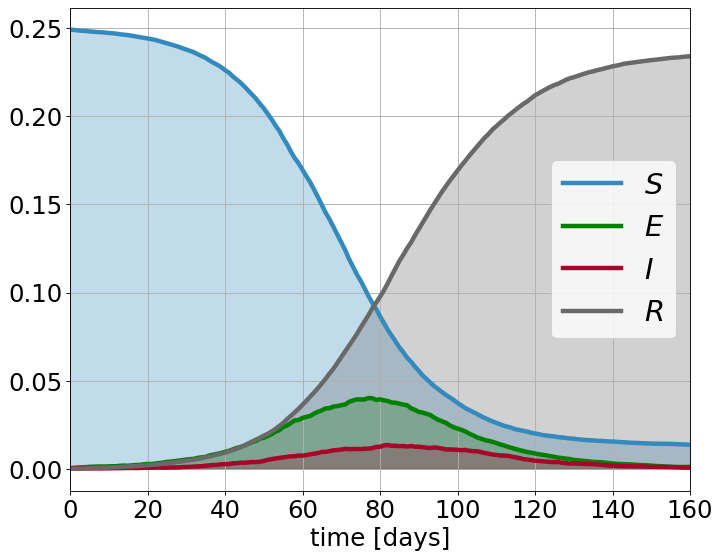

In [4]:
# plot the data and obtain the epidemic curve for one age group 
S  = data_array[:,0]
E  = data_array[:,2]
Ia = data_array[:,4]
Is = data_array[:,6]
t  = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.plot(t, E/N, '-', color="green", label='$E$', lw=4)
plt.fill_between(t, 0, E/N, color='green', alpha=0.3)

plt.fill_between(t, 0, Is/N, color='#A60628', alpha=0.3)
plt.plot(t, Is/N, '-', color='#A60628', label='$I$', lw=4)

R=Ni[0]-S-Ia-Is-E; 
plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("time [days]")
plt.show()

## 2) Compute the information gain for $I_\mathrm{s}$
We take the first $60$ data points of the $I_\mathrm{s}$ trajectory.

In [5]:
# Only collect Is 
# load the data and rescale to intensive variables 
N_start = 20  
Tf_inference = 40 # can truncate later 
Nf_inference = Tf_inference + 1

x = np.load('latent_SEIR_traj.npy').astype('float')
x = (x/N)[N_start:N_start+Nf_inference]
steps = 4 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator1 = pyross.inference.SEIR(parameters, M, fi, int(N), steps)


# make a fltr to get Is for each age class 
fltr1=np.kron([[0, 0, 0, 1]], np.identity(M))
obs1=np.einsum('ij,kj->ki', fltr1, x) 
x0=x[0]

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
estimator1.set_det_model(parameters)
estimator1.set_contact_matrix(contactMatrix)

In [6]:
# Make parameter guesses (and define bounds for the MAP estimate later)
eps = 1e-3

param_priors = {
    'beta':{
        'mean': 0.02, 
        'std': 0.1,
        'bounds': [eps, 5]
    },
    'gIa':{
        'mean': 0.12, 
        'std': 0.1, 
        'bounds': [eps, 5]
    }, 
    'gIs':{
        'mean': 0.14, 
        'std': 0.05, 
        'bounds': [eps, 5]
    },
    'gE':{
        'mean': 0.1, 
        'std': 0.05, 
        'bounds': [eps, 5]
    }
}

fsa_g = 0.8 # not inferred 

S0_g = x0[:1*M]
S_std = S0_g*0.3 
bounds_for_S = np.tile([1e4/N, 5e4/N], M).reshape(M, 2)

E0_g = x0[M:2*M]
E_std = E0_g*0.3 
bounds_for_E = np.tile([0.1/N, 500/N], M).reshape(M, 2)

Ia0_g = x0[2*M:3*M]
Ia_std = Ia0_g 
bounds_for_Ia = np.tile([0.1/N, 500/N], M).reshape(M, 2)

init_fltr = np.repeat([True, True, True, False], M)
init_priors = {
    'independent': {
        'fltr': init_fltr,
        'mean': [*S0_g, *E0_g, *Ia0_g],
        'std': [*S_std, *E_std, *Ia_std],
        'bounds': [*bounds_for_S, *bounds_for_E, *bounds_for_Ia]
    }
}

start_time = time.time()
result1, samples1 = estimator1.nested_sampling_latent_inference(obs1, fltr1, Tf_inference, contactMatrix, param_priors, init_priors,  
                                                    tangent=True, max_iter=2500, verbose=True, npoints=100) 
end_time = time.time()
print(end_time - start_time)

Iteration 100: log_evidence = -1109.0026987548708
Iteration 200: log_evidence = 471.3035760374115
Iteration 300: log_evidence = 569.5486023636992
Iteration 400: log_evidence = 597.7102720301016
Iteration 500: log_evidence = 608.411476262711
Iteration 600: log_evidence = 614.2001896491691
Iteration 700: log_evidence = 617.0683606302616
Iteration 800: log_evidence = 618.7560470696997
Iteration 900: log_evidence = 619.908817986897
Iteration 1000: log_evidence = 620.5706706986501
Iteration 1100: log_evidence = 620.9343317557849
Iteration 1200: log_evidence = 621.1383710718654
202.74713706970215


In [7]:
print("Information in the posterior relative to the prior after\nacquiring data on symptomatic infected individuals: ", result1.h)

Information in the posterior relative to the prior after
acquiring data on symptomatic infected individuals:  8.394513569683795


## 2) Compute the information gain for $N-R$ 
We take the first $60$ data points of the $N-R$ (this is the workaround to record the number of recovered individuals) trajectory.

In [8]:
# Only collect N-R
# load the data and rescale to intensive variables 
N_start = 20  
Tf_inference = 40 # can truncate later 
Nf_inference = Tf_inference + 1

x = np.load('latent_SEIR_traj.npy').astype('float')
x = (x/N)[N_start:N_start+Nf_inference]
steps = 4 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator2 = pyross.inference.SEIR(parameters, M, fi, int(N), steps)


# make a fltr to get N-R for each age class 
fltr2=np.kron([[1, 1, 1, 1]], np.identity(M))
obs2=np.einsum('ij,kj->ki', fltr2, x) 
x0=x[0]

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
estimator2.set_det_model(parameters)
estimator2.set_contact_matrix(contactMatrix)

In [9]:
# Make parameter guesses (and define bounds for the MAP estimate later)
eps = 1e-3

param_priors = {
    'beta':{
        'mean': 0.02, 
        'std': 0.1,
        'bounds': [eps, 5]
    },
    'gIa':{
        'mean': 0.12, 
        'std': 0.1, 
        'bounds': [eps, 5]
    }, 
    'gIs':{
        'mean': 0.14, 
        'std': 0.05, 
        'bounds': [eps, 5]
    },
    'gE':{
        'mean': 0.1, 
        'std': 0.05, 
        'bounds': [eps, 5]
    }
}

fsa_g = 0.8 # not inferred 

E0_g = x0[M:2*M]
E_std = E0_g*0.3 
bounds_for_E = np.tile([0.1/N, 500/N], M).reshape(M, 2)

Ia0_g = x0[2*M:3*M]
Ia_std = Ia0_g 
bounds_for_Ia = np.tile([0.1/N, 500/N], M).reshape(M, 2)

Is0_g = x0[3*M:4*M]
Is_std = Is0_g 
bounds_for_Is = np.tile([0.1/N, 500/N], M).reshape(M, 2)

init_fltr = np.repeat([False, True, True, True], M)
init_priors = {
    'independent': {
        'fltr': init_fltr,
        'mean': [*E0_g, *Ia0_g, *Is0_g],
        'std': [*E_std, *Ia_std, *Is_std],
        'bounds': [*bounds_for_E, *bounds_for_Ia, *bounds_for_Is]
    }
}

start_time = time.time()
result2, samples2 = estimator2.nested_sampling_latent_inference(obs2, fltr2, Tf_inference, contactMatrix, param_priors, init_priors,  
                                                    tangent=True, max_iter=2500, verbose=True, npoints=100) 
end_time = time.time()
print(end_time - start_time)

Iteration 100: log_evidence = -2892.829787810794
Iteration 200: log_evidence = 263.0216635972283
Iteration 300: log_evidence = 557.1873020004147
Iteration 400: log_evidence = 621.4842871627942
Iteration 500: log_evidence = 643.0661546711864
Iteration 600: log_evidence = 650.8364074037554
Iteration 700: log_evidence = 655.7574680759534
Iteration 800: log_evidence = 657.938376293662
Iteration 900: log_evidence = 658.9245705774226
Iteration 1000: log_evidence = 659.558991809474
Iteration 1100: log_evidence = 659.9366388990919
239.6485891342163


In [10]:
print("Information in the posterior relative to the prior after\nacquiring data on recovered (N-R) individuals: ", result2.h)

Information in the posterior relative to the prior after
acquiring data on recovered (N-R) individuals:  8.321593484990558


In [14]:
print("The relative information gain of collecting data on symptomatic\ninfected to recovered individuals is: ", result1.h/result2.h)

The relative information gain of collecting data on symptomatic
infected to recovered individuals is:  1.0087627549729221
